<a href="https://colab.research.google.com/github/pgmpy/pgmpy_notebook/blob/master/notebooks/3.%20Causal%20Bayesian%20Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Causal Bayesian Networks

Causal Inference is a new feature for pgmpy, so I wanted to develop a few examples which show off the features that we're developing! 

This particular notebook walks through the 5 games that used as examples for building intuition about backdoor paths in *The Book of Why* by Judea Peal. I have consistently been using them to test different implementations of backdoor adjustment from different libraries and include them as unit tests in pgmpy, so I wanted to walk through them and a few other related games as a potential resource to both understand the implementation of CausalInference in pgmpy, as well as develope some useful intuitions about backdoor paths. 

## Objective of the Games

For each game we get a causal graph, and our goal is to identify the set of deconfounders (often denoted $Z$) which will close all backdoor paths from nodes $X$ to $Y$. For the time being, I'll assume that you're familiar with the concept of backdoor paths, though I may expand this portion to explain it. 

In [21]:
#@title Clone the Development Repo & Install Requirements
#@markdown Because the Causal Inference class is currently in dev, we will actually need to pull the code from GitHub.  This cell will give us a pretty good development environment for interactively developing and testing the CausalModel class and its methods.
#@markdown You only need to run this the first time you've started the kernel.
%%sh
git clone https://github.com/mrklees/pgmpy.git
mv /content/pgmpy /content/pgmpydev
cd pgmpydev/
git checkout feature/causalmodel
git pull
#@markdown In testing the CausalModel and Bayesian Network portion of pgmpy we've actually been able to use up to date version of Networkx and other packages, but we may be forced to downgrade to networkx 1.11 if errors arise.
#pip install -U -r requirements-dev.txt

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Your branch is up to date with 'origin/feature/causalmodel'.
Updating c459420..95af23b
Fast-forward
 pgmpy/inference/causal_inference.py                 | 14 +++++++-------
 pgmpy/tests/test_inference/test_causal_inference.py |  2 +-
 2 files changed, 8 insertions(+), 8 deletions(-)


fatal: destination path 'pgmpy' already exists and is not an empty directory.
mv: cannot move '/content/pgmpy' to '/content/pgmpydev/pgmpy': Directory not empty
Already on 'feature/causalmodel'
From https://github.com/mrklees/pgmpy
   c459420..95af23b  feature/causalmodel -> origin/feature/causalmodel


In [3]:
#@title Imports
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/content/pgmpydev')

!pip3 install -q daft
import matplotlib.pyplot as plt
%matplotlib inline
import daft
from daft import PGM

# We can now import the development version of pgmpy
from pgmpy.models.BayesianModel import BayesianModel
from pgmpy.inference import CausalInference

def convert_pgm_to_pgmpy(pgm):
    """Takes a Daft PGM object and converts it to a pgmpy BayesianModel"""
    edges = [(edge.node1.name, edge.node2.name) for edge in pgm._edges]
    model = BayesianModel(edges)
    return model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ModuleNotFoundError: No module named 'statsmodels'

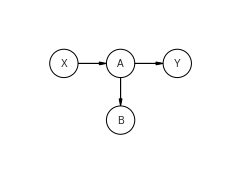

In [23]:
#@title # Game 1
#@markdown While this is a "trivial" example, many statisticians would consider including either or both A and B in their models "just for good measure".  Notice though how controlling for A would close off the path of causal information from X to Y, actually *impeding* your effort to measure that effect.
pgm = PGM(shape=[4, 3])

pgm.add_node(daft.Node('X', r"X", 1, 2))
pgm.add_node(daft.Node('Y', r"Y", 3, 2))
pgm.add_node(daft.Node('A', r"A", 2, 2))
pgm.add_node(daft.Node('B', r"B", 2, 1))


pgm.add_edge('X', 'A')
pgm.add_edge('A', 'Y')
pgm.add_edge('A', 'B')

pgm.render()
plt.show()

In [24]:
#@markdown Notice how there are no nodes with arrows pointing into X.  Said another way, X has no parents.  Therefore, there can't be any backdoor paths confounding X and Y.  pgmpy will confirm this in the following way:
game1 = convert_pgm_to_pgmpy(pgm)
inference1 = CausalInference(game1)
print(f"Are there are active backdoor paths? {inference1._has_active_backdoors('X', 'Y')}")
adj_sets = inference1.get_all_backdoor_adjustment_sets("X", "Y")
print(f"If so, what's the possible backdoor adjustment sets? {adj_sets}")

Are there are active backdoor paths? False
If so, what's the possible backdoor adjustment sets? frozenset()


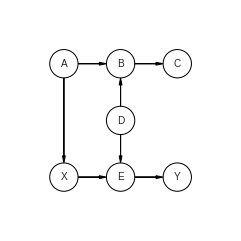

In [25]:
#@title # Game 2
#@markdown This graph looks harder, but actualy is also trivial to solve.  The key is noticing the one backdoor path, which goes from X <- A -> B <- D -> E -> Y, has a collider at B (or a 'V structure'), and therefore the backdoor path is closed. 
pgm = PGM(shape=[4, 4])

pgm.add_node(daft.Node('X', r"X", 1, 1))
pgm.add_node(daft.Node('Y', r"Y", 3, 1))
pgm.add_node(daft.Node('A', r"A", 1, 3))
pgm.add_node(daft.Node('B', r"B", 2, 3))
pgm.add_node(daft.Node('C', r"C", 3, 3))
pgm.add_node(daft.Node('D', r"D", 2, 2))
pgm.add_node(daft.Node('E', r"E", 2, 1))


pgm.add_edge('X', 'E')
pgm.add_edge('A', 'X')
pgm.add_edge('A', 'B')
pgm.add_edge('B', 'C')
pgm.add_edge('D', 'B')
pgm.add_edge('D', 'E')
pgm.add_edge('E', 'Y')

pgm.render()
plt.show()

In [26]:
graph = convert_pgm_to_pgmpy(pgm)
inference = CausalInference(graph)
print(f"Are there are active backdoor paths? {inference._has_active_backdoors('X', 'Y')}")
adj_sets = inference.get_all_backdoor_adjustment_sets("X", "Y")
print(f"If so, what's the possible backdoor adjustment sets? {adj_sets}")

Are there are active backdoor paths? False
If so, what's the possible backdoor adjustment sets? frozenset()


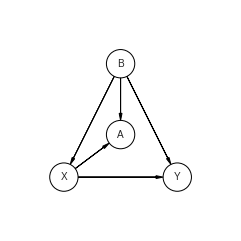

In [27]:
#@title # Game 3
#@markdown This game actually requires some action.  Notice the backdoor path X <- B -> Y.  This is a confounding pattern, is one of the clearest signs that we'll need to control for something, in this case B. 
pgm = PGM(shape=[4, 4])

pgm.add_node(daft.Node('X', r"X", 1, 1))
pgm.add_node(daft.Node('Y', r"Y", 3, 1))
pgm.add_node(daft.Node('A', r"A", 2, 1.75))
pgm.add_node(daft.Node('B', r"B", 2, 3))


pgm.add_edge('X', 'Y')
pgm.add_edge('X', 'A')
pgm.add_edge('B', 'A')
pgm.add_edge('B', 'X')
pgm.add_edge('B', 'Y')

pgm.render()
plt.show()

In [28]:
graph = convert_pgm_to_pgmpy(pgm)
inference = CausalInference(graph)
print(f"Are there are active backdoor paths? {inference._has_active_backdoors('X', 'Y')}")
adj_sets = inference.get_all_backdoor_adjustment_sets("X", "Y")
print(f"If so, what's the possible backdoor adjustment sets? {adj_sets}")

Are there are active backdoor paths? True
If so, what's the possible backdoor adjustment sets? frozenset({frozenset({'B'})})


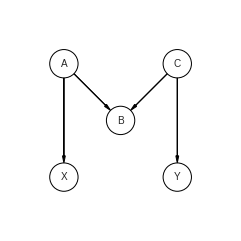

In [29]:
#@title # Game 4
#@markdown Pearl named this particular configuration "M Bias", not only because of it's shape, but also because of the common practice of statisticians to want to control for B in many situations.  However, notice how in this configuration X and Y start out as *not confounded* and how by controlling for B we would actually introduce confounding by opening the path at the collider, B. 
pgm = PGM(shape=[4, 4])

pgm.add_node(daft.Node('X', r"X", 1, 1))
pgm.add_node(daft.Node('Y', r"Y", 3, 1))
pgm.add_node(daft.Node('A', r"A", 1, 3))
pgm.add_node(daft.Node('B', r"B", 2, 2))
pgm.add_node(daft.Node('C', r"C", 3, 3))


pgm.add_edge('A', 'X')
pgm.add_edge('A', 'B')
pgm.add_edge('C', 'B')
pgm.add_edge('C', 'Y')

pgm.render()
plt.show()

In [30]:
graph = convert_pgm_to_pgmpy(pgm)
inference = CausalInference(graph)
print(f"Are there are active backdoor paths? {inference._has_active_backdoors('X', 'Y')}")
adj_sets = inference.get_all_backdoor_adjustment_sets("X", "Y")
print(f"If so, what's the possible backdoor adjustment sets? {adj_sets}")

Are there are active backdoor paths? False
If so, what's the possible backdoor adjustment sets? frozenset()


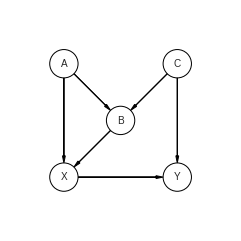

In [31]:
#@title # Game 5
#@markdown This is the last game in The Book of Why is the most complex.  In this case we have two backdoor paths, one going through A and the other through B, and it's important to notice that if we only control for B that the path: X <- A -> B <- C -> Y (which starts out as closed because B is a collider) actually is opened.  Therefore we have to either close both A and B or, as astute observers will notice, we can also just close C and completely close both backdoor paths.  pgmpy will nicely confirm these results for us. 
pgm = PGM(shape=[4, 4])

pgm.add_node(daft.Node('X', r"X", 1, 1))
pgm.add_node(daft.Node('Y', r"Y", 3, 1))
pgm.add_node(daft.Node('A', r"A", 1, 3))
pgm.add_node(daft.Node('B', r"B", 2, 2))
pgm.add_node(daft.Node('C', r"C", 3, 3))


pgm.add_edge('A', 'X')
pgm.add_edge('A', 'B')
pgm.add_edge('C', 'B')
pgm.add_edge('C', 'Y')
pgm.add_edge("X", "Y")
pgm.add_edge("B", "X")

pgm.render()
plt.show()

In [32]:
graph = convert_pgm_to_pgmpy(pgm)
inference = CausalInference(graph)
print(f"Are there are active backdoor paths? {inference._has_active_backdoors('X', 'Y')}")
adj_sets = inference.get_all_backdoor_adjustment_sets("X", "Y")
print(f"If so, what's the possible backdoor adjustment sets? {adj_sets}")

Are there are active backdoor paths? True
If so, what's the possible backdoor adjustment sets? frozenset({frozenset({'B', 'A'}), frozenset({'C'})})


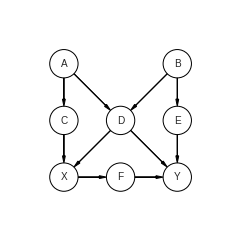

In [36]:
#@title # Game 6
#@markdown So these are no longer drawn from The Book of Why, but were either drawn from another source (which I will reference) or a developed to try to induce a specific bug. 
#@markdown This example is drawn from Causality by Pearl on p. 80. This example is kind of interesting because there are many possible combinations of nodes which will close the two backdoor paths which exist in this graph.  In turns out that D plus any other node in {A, B, C, E} will deconfound X and Y. 

pgm = PGM(shape=[4, 4])

pgm.add_node(daft.Node('X', r"X", 1, 1))
pgm.add_node(daft.Node('Y', r"Y", 3, 1))
pgm.add_node(daft.Node('A', r"A", 1, 3))
pgm.add_node(daft.Node('B', r"B", 3, 3))
pgm.add_node(daft.Node('C', r"C", 1, 2))
pgm.add_node(daft.Node('D', r"D", 2, 2))
pgm.add_node(daft.Node('E', r"E", 3, 2))
pgm.add_node(daft.Node('F', r"F", 2, 1))


pgm.add_edge('X', 'F')
pgm.add_edge('F', 'Y')
pgm.add_edge('C', 'X')
pgm.add_edge('A', 'C')
pgm.add_edge('A', 'D')
pgm.add_edge('D', 'X')
pgm.add_edge('D', 'Y')
pgm.add_edge('B', 'D')
pgm.add_edge('B', 'E')
pgm.add_edge('E', 'Y')

pgm.render()
plt.show()

In [38]:
graph = convert_pgm_to_pgmpy(pgm)
inference = CausalInference(graph)
print(f"Are there are active backdoor paths? {inference._has_active_backdoors('X', 'Y')}")
bd_adj_sets = inference.get_all_backdoor_adjustment_sets("X", "Y")
print(f"If so, what's the possible backdoor adjustment sets? {bd_adj_sets}")
fd_adj_sets = inference.get_all_frontdoor_adjustment_sets("X", "Y")
print(f"Ehat's the possible front adjustment sets? {fd_adj_sets}")

Are there are active backdoor paths? True
If so, what's the possible backdoor adjustment sets? frozenset({frozenset({'B', 'D'}), frozenset({'A', 'D'}), frozenset({'C', 'D'}), frozenset({'E', 'D'})})
Ehat's the possible front adjustment sets? frozenset({frozenset({'F'})})


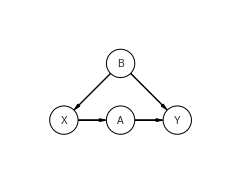

In [40]:
#@title # Game 7
#@markdown This game tests the front door adjustment.  B is taken to be unobserved, and therfore we cannot close the backdoor path X <- B -> Y. 
pgm = PGM(shape=[4, 3])

pgm.add_node(daft.Node('X', r"X", 1, 1))
pgm.add_node(daft.Node('Y', r"Y", 3, 1))
pgm.add_node(daft.Node('A', r"A", 2, 1))
pgm.add_node(daft.Node('B', r"B", 2, 2))


pgm.add_edge('X', 'A')
pgm.add_edge('A', 'Y')
pgm.add_edge('B', 'X')
pgm.add_edge('B', 'Y')

pgm.render()
plt.show()

In [41]:
graph = convert_pgm_to_pgmpy(pgm)
inference = CausalInference(graph)
print(f"Are there are active backdoor paths? {inference._has_active_backdoors('X', 'Y')}")
bd_adj_sets = inference.get_all_backdoor_adjustment_sets("X", "Y")
print(f"If so, what's the possible backdoor adjustment sets? {bd_adj_sets}")
fd_adj_sets = inference.get_all_frontdoor_adjustment_sets("X", "Y")
print(f"Ehat's the possible front adjustment sets? {fd_adj_sets}")

Are there are active backdoor paths? True
If so, what's the possible backdoor adjustment sets? frozenset({frozenset({'B'})})
Ehat's the possible front adjustment sets? frozenset({frozenset({'A'})})
